# 5. しきい値判定を行い、条件下で計測マーカーを打つ

このケースでは、以下の方法を中心に解説します。

* サーバー側に保存された数値データを取得し、特定のしきい値が超える区間を算出する
* 特定の区間に対して、計測のタグ情報を付与する

```
Warning: 
    計測マーカーの登録機能は、intdash-apiのバージョン v1.10.0 以降で使用可能です。
```

## シナリオ
本シナリオでは、iOSアプリケーション  **intdash Motion** を活用しiPhoneのセンサーデータを取得します。加速度にしきい値を設けて、加速度が極端に大きくなっている時刻を特定し、その時刻に「Status : Exceeds threshold」 というタグを登録します。

## 事前準備

本シナリオを実施する前に、以下を用意する必要があります。

- 計測用のエッジ
- intdash Motion アプリでアップロードした計測(センサーデータを含む)

### 使用データ
本シナリオでは、事前に以下のデータをサーバー側に準備する必要があります。  
使用する時系列データは **「1. 時系列データを取得し、CSVで保存する」**で作成した計測データを使用します。  

|データ項目|本シナリオで登場するデータ名|
|:---|:---|
|時系列データを登録するエッジ|sdk_edge1|
|計測情報 (※)|measurement1|
|信号定義| sp_ACCX, sp_ACCY, sp_ACCZ |

(※) 使用する時系列データは **「1. 取得した時系列データをCSVで保存する」**  と同様に、intdash Motionを使用して時系列データを登録します。


### パッケージのimportとクライアントの生成
`intdash.Client` に与える `url` は intdashサーバーの環境情報から、 `edge_token` はログイン用エッジで発行したトークンを指定してください。  
(※ `username` と `password` でのログインも可能ですが、継続して動作する場合はエッジトークンの使用を推奨します)

In [1]:
import pandas as pd

import intdash
from intdash import timeutils

# Create client
client = intdash.Client(
    url = "https://example.intdash.jp",
    edge_token = "your_token",
)

### 信号定義を登録する

「1.時系列データを取得し、CSVで保存する」 で使用した信号定義と同じ信号定義を使います。
汎用センサー型から数値に変更するための実行ファイルは、以下を確認してください。

[汎用センサー（General Sensor）型向け 信号定義サンプル](https://docs.intdash.jp/sdk/python/latest/ja/guide/signals/generalsensor.html) 

本シナリオでは、「汎用センサー型」のうち、「加速度」に対してのみ変換定義を登録します。  

### 信号定義が登録されていることを確認する
上記で登録した信号定義を確認します。

In [3]:
signals = client.signals.list(label='sp')

In [4]:
for s in signals:
    print(s.label,  end=', ')

sp_ACCX, sp_ACCY, sp_ACCZ, 

## 計測に使用したエッジを取得する

In [46]:
edges = client.edges.list(name='sdk_edge1')
sdk_edge1 = edges[0]

In [47]:
sdk_edge1.name

'sdk_edge1'

## 取得したい計測を取得する
計測のuuidを使用して検索したい場合は計測情報を取得します。  
最初の取得時には `list()` を使用して時間指定を行います。  

In [48]:
ms = client.measurements.list(
    edge_uuid=sdk_edge1.uuid,
    start=timeutils.str2timestamp('2020-07-17 00:00:00+09:00'),
    end=timeutils.str2timestamp('2020-07-18 00:00:00+09:00'),
)

In [49]:
# Because there is only one measurement associated with `sdk_edge1`, it is specified as follows.
measurement1 = ms[0]
print(measurement1)

uuid: 8a88c664-e12b-4b26-9899-b4b35a56274f
name: 
description: 
edge_uuid: e7449602-6337-4039-a9dd-fbce9a8bba85
duration: 0 days 00:00:51.718971
ended: True
basetime: 2020-07-17 01:21:45.638134+00:00
basetime_type: manual
processed_ratio: 1
protected: False
markers: []
created_at: 2020-07-21 11:31:49.902911+00:00
updated_at: 2020-07-21 11:31:59.373162+00:00


## 時系列データを取得する
本シナリオでは、時系列データの取得には ` client.data_points` を使用します。  
`labels` に、事前に登録している信号定義のラベル名を指定して実行します。  
`start` および `end` は前述の手順で作成した計測を含む時刻に変更してください。

In [55]:
dps = client.data_points.list(
    edge_name='sdk_edge1',
    start=timeutils.str2timestamp('2020-07-17 00:00:00+09:00'), # change appropriately.
    end=timeutils.str2timestamp('2020-07-18 00:00:00+09:00'), # change appropriately.
    labels=['sp_ACCX', 'sp_ACCY', 'sp_ACCZ'],
    limit=0
)

In [56]:
print(dps[0])

time: 2020-07-17T01:21:45.911747000Z
measurement_uuid: fc3019f8-3b52-4e66-848e-780c4d0ff572
data_type: 11
channel: 1
data_id: sp_ACCZ
data_payload: b'\x07sp_ACCZ\xe8\x80$\xec\xdbI\xca?'


## 時系列データを可視化する
「1. 取得した時系列データを、CSVで保存する」を参考に、DataFrameに変換します。その後 `matplotlib` を使用してデータを可視化し、しきい値を検討します。

In [59]:
from intdash import data

df = pd.DataFrame( [ {
        'time':d.time,
        d.data_id:data.Float.from_payload(d.data_payload).value
    }
    for d in dps
]).groupby("time").last()


`matplotlib` を使用すると、以下のようにグラフとして可視化することができます。  
グラフを観察すると、 `sp_ACCZ` が極端に大きな値になっている個所があります。そこで、10を超えた箇所を `Exceeds threshold`としてタグに登録します。

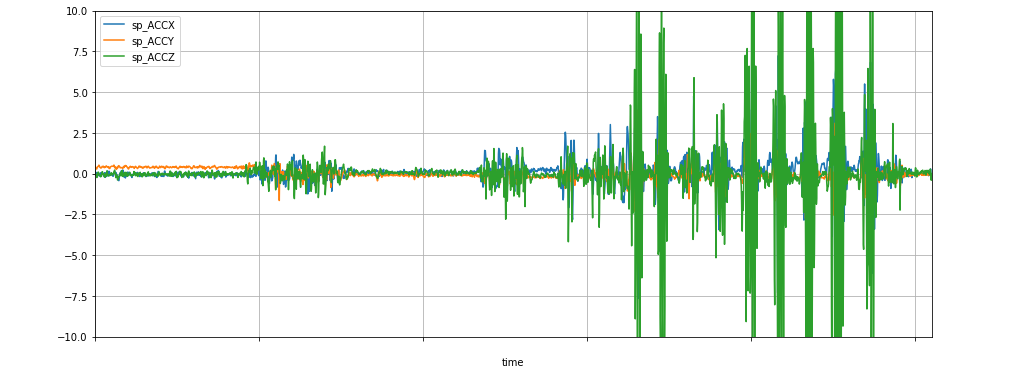

In [15]:
from matplotlib import pyplot as plt

df.plot(figsize=(15,6), grid=True, ylim=[-10, 10])

plt.xticks(color="None")
plt.show()
plt.close()

## 取得した時系列データに対して、しきい値判定を行う
取得したデータに対し、`sp_ACCZ` が10を超えた箇所のみタグを打ちます。

In [60]:
THRESHOLD = 10 
tags= [] # Tags list for register.

for d in dps:
    value = data.Float.from_payload(d.data_payload).value
    
    if value > THRESHOLD:
        tag = {
            d.data_id : 'Exceeds threshold'
        }
        
        # Create measurements.
        client.measurement_markers.create(
            measurement_uuid=measurement1.uuid,
            type='point',
            detail=intdash.MeasurementMarkerDetailPoint(
                # Time elapsed from the start of measurement.
                occurred_elapsed_time=timeutils.str2timestamp(d.time) - measurement1.basetime
            ),
            tag=tag
        )
        

## 登録した計測マーカーを確認する
登録されたマーカーを確認します。

In [61]:
markers = client.measurement_markers.list(
    measurement_uuid=measurement1.uuid
)

In [62]:
print(markers[0])

uuid: 00dc476a-c5d2-444b-9c7f-8824ab098664
name: 
description: 
type: point
detail: occurred_elapsed_time: 0 days 00:00:48.068660
tag: {'sp_ACCZ': 'Exceeds threshold'}
created_at: 2020-07-21T11:41:10.992034Z
created_by: a7565571-a284-4d10-8923-196701d283a2
updated_at: 2020-07-21T11:41:10.992034Z
updated_by: a7565571-a284-4d10-8923-196701d283a2


計測マーカーは、**Visual M2M Data Visualizer** にて確認することができます。
1. Stored Data を開きます。
2. 左メニューの Markers を選択します。
3. 右側に Markers (計測マーカー) の一覧が表示されます。

<img src="https://github.com/aptpod/intdash-py-samples/blob/master/img/img4.png?raw=true">